In [20]:
!pip install -U keras-tuner

import pandas as pd
import numpy as np
import random
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from kerastuner.tuners import RandomSearch
from kerastuner.engine import hyperparameters
from keras.layers import Dropout
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import time
import math
import matplotlib.pyplot as plt
from keras import utils
from sklearn.preprocessing import MinMaxScaler

Requirement already up-to-date: keras-tuner in /usr/local/lib/python3.6/dist-packages (1.0.1)


In [21]:
TRAIN_FILE_PATH = '/content/drive/My Drive/ИАД/train.csv'

# загружаем данные
x = pd.read_csv(TRAIN_FILE_PATH) 
print("LOADED DATA")
print(x)

LOADED DATA
        ID       y  X0 X1  X2 X3 X4  ... X378 X379 X380  X382  X383  X384  X385
0        0  130.81   k  v  at  a  d  ...    0    0    0     0     0     0     0
1        6   88.53   k  t  av  e  d  ...    0    0    0     0     0     0     0
2        7   76.26  az  w   n  c  d  ...    0    0    0     1     0     0     0
3        9   80.62  az  t   n  f  d  ...    0    0    0     0     0     0     0
4       13   78.02  az  v   n  f  d  ...    0    0    0     0     0     0     0
...    ...     ...  .. ..  .. .. ..  ...  ...  ...  ...   ...   ...   ...   ...
4204  8405  107.39  ak  s  as  c  d  ...    0    0    0     0     0     0     0
4205  8406  108.77   j  o   t  d  d  ...    0    0    0     0     0     0     0
4206  8412  109.22  ak  v   r  a  d  ...    0    0    0     0     0     0     0
4207  8415   87.48  al  r   e  f  d  ...    0    0    0     0     0     0     0
4208  8417  110.85   z  r  ae  c  d  ...    0    0    0     0     0     0     0

[4209 rows x 378 columns]


In [22]:
y = x.get('y') # TRUE VALUES
x.drop('y', axis='columns', inplace=True)
x.drop('ID', axis='columns', inplace=True)
print("DATA without ID and Y:")
print(x)


DATA without ID and Y:
      X0 X1  X2 X3 X4  X5 X6 X8  ...  X377  X378  X379  X380  X382  X383  X384  X385
0      k  v  at  a  d   u  j  o  ...     1     0     0     0     0     0     0     0
1      k  t  av  e  d   y  l  o  ...     0     0     0     0     0     0     0     0
2     az  w   n  c  d   x  j  x  ...     0     0     0     0     1     0     0     0
3     az  t   n  f  d   x  l  e  ...     0     0     0     0     0     0     0     0
4     az  v   n  f  d   h  d  n  ...     0     0     0     0     0     0     0     0
...   .. ..  .. .. ..  .. .. ..  ...   ...   ...   ...   ...   ...   ...   ...   ...
4204  ak  s  as  c  d  aa  d  q  ...     0     0     0     0     0     0     0     0
4205   j  o   t  d  d  aa  h  h  ...     0     0     0     0     0     0     0     0
4206  ak  v   r  a  d  aa  g  e  ...     1     0     0     0     0     0     0     0
4207  al  r   e  f  d  aa  l  u  ...     0     0     0     0     0     0     0     0
4208   z  r  ae  c  d  aa  g  w  ...     0

Эта функция находит столбцы со всеми нулями, кроме первой строчки. Удаляем эти столбцы, чтобы получить данные лучше

In [23]:
suspicious_data = []
for col in x:
    if len(x[col].unique()) == 1:
        suspicious_data.append(col)
x[suspicious_data].describe()
x.drop(suspicious_data, 1, inplace = True)

Находим ТОЛЬКО те столбцы, где данные хранятся в виде букв.
Обрабатываем через Encoder только их

In [24]:
cat_vars = [var for var in x.columns if x[var].dtypes == 'O']
print('Number of categorical variables: ', len(cat_vars))

x[cat_vars]

Number of categorical variables:  8


,X0,X1,X2,X3,X4,X5,X6,X8
0,k,v,at,a,d,u,j,o
1,k,t,av,e,d,y,l,o
2,az,w,n,c,d,x,j,x
3,az,t,n,f,d,x,l,e
4,az,v,n,f,d,h,d,n
...,...,...,...,...,...,...,...,...
4204,ak,s,as,c,d,aa,d,q
4205,j,o,t,d,d,aa,h,h
4206,ak,v,r,a,d,aa,g,e
4207,al,r,e,f,d,aa,l,u


Переводим в числа найденные столбцы 

In [25]:
df = pd.DataFrame(x[cat_vars])
x[cat_vars] = df.apply(preprocessing.LabelEncoder().fit_transform)

x[cat_vars]

,X0,X1,X2,X3,X4,X5,X6,X8
0,32,23,17,0,3,24,9,14
1,32,21,19,4,3,28,11,14
2,20,24,34,2,3,27,9,23
3,20,21,34,5,3,27,11,4
4,20,23,34,5,3,12,3,13
...,...,...,...,...,...,...,...,...
4204,8,20,16,2,3,0,3,16
4205,31,16,40,3,3,0,7,7
4206,8,23,38,0,3,0,6,4
4207,9,19,25,5,3,0,11,20


Нормализуем данные через MinMaxScaler

In [26]:
scaler = MinMaxScaler() # функция нормализации данных (от 0 до 1)
x[cat_vars] = scaler.fit_transform(x[cat_vars])

print(x)

            X0        X1        X2        X3   X4  ...  X380  X382  X383  X384  X385
0     0.695652  0.884615  0.395349  0.000000  1.0  ...     0     0     0     0     0
1     0.695652  0.807692  0.441860  0.666667  1.0  ...     0     0     0     0     0
2     0.434783  0.923077  0.790698  0.333333  1.0  ...     0     1     0     0     0
3     0.434783  0.807692  0.790698  0.833333  1.0  ...     0     0     0     0     0
4     0.434783  0.884615  0.790698  0.833333  1.0  ...     0     0     0     0     0
...        ...       ...       ...       ...  ...  ...   ...   ...   ...   ...   ...
4204  0.173913  0.769231  0.372093  0.333333  1.0  ...     0     0     0     0     0
4205  0.673913  0.615385  0.930233  0.500000  1.0  ...     0     0     0     0     0
4206  0.173913  0.884615  0.883721  0.000000  1.0  ...     0     0     0     0     0
4207  0.195652  0.730769  0.581395  0.833333  1.0  ...     0     0     0     0     0
4208  1.000000  0.730769  0.069767  0.333333  1.0  ...     0     

Делим данные на тренировочные и тестовые

In [27]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0, test_size = 0.3)

Создаем модель вручную

In [28]:
model = Sequential()

model.add(Dense(512, activation='relu', input_shape=(x_train.shape[1],)))
model.add(Dropout(0.1))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1))


model.compile(loss='mse', optimizer='adam', metrics=['mae'])
model.summary()
history = model.fit(x_train, y_train, epochs=100, batch_size=128, validation_split=0.2)
history = history.history

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 512)               186880    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

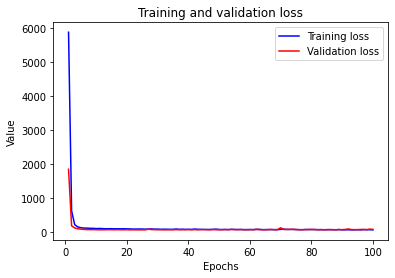

In [29]:
def draw_graph(history):
    loss_values = history["loss"]
    validation_loss_values = history["val_loss"]

    epochs = range(1, len(history['loss']) + 1)

    plt.plot(epochs, loss_values, 'b', label='Training loss')
    plt.plot(epochs, validation_loss_values, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

draw_graph(history)

In [30]:
print("[INFO] RUNNING ON TEST DATA: \n")
mse, mae = model.evaluate(x_test, y_test, verbose=0, batch_size=128)
print(f"[INFO] Mean squared error is {mse}")
print(f"[INFO] Mean absolute error is {mae}")

[INFO] RUNNING ON TEST DATA: 

[INFO] Mean squared error is 108.32121276855469
[INFO] Mean absolute error is 7.137434005737305


Создаем модель для тюнера

In [31]:
def build_model(hp):
  hidden_layers = hp.Choice('hidden_layers', values=[1,2,3])
  activation_choice = hp.Choice('activation', values=['relu', 'selu', 'elu'])
  model = Sequential()
  model.add(Dense(units=hp.Int('units',min_value=256,max_value=512,step=32),activation=activation_choice, input_shape=(x_train.shape[1], ), kernel_regularizer=L2(0.001)))
  model.add(Dropout(0.3))
  for i in range(hidden_layers):
    model.add(Dense(units=hp.Int(f'layer_{i}_units_',min_value=32//(i+1), max_value=128//(i+1),step=64//(i+1)),activation=activation_choice, kernel_regularizer=L2(0.001)))
  model.add(Dense(1))  
  model.compile(optimizer='rmsprop', loss="mse", metrics=["mae"])
  return model

Запускаем поиск лучшей модели с помощью тюнера

In [32]:
def find_best_NN(x_train, y_train):
  tuner = RandomSearch(build_model, objective="loss", max_trials=10, executions_per_trial=1)
  print("\n\n\n")
  print('[INFO] start searching')
  tuner.search(x_train, y_train, batch_size=100, epochs=10, validation_split=0.2)
  print("\n\n\nRESULTS SUMMARY")
  tuner.results_summary()
  print("\n\n\n")
  print("\n\n\nHERE IS THE BEST MODEL\n\n\n")
  best_params = tuner.get_best_hyperparameters()[0]
  best_model = tuner.hypermodel.build(best_params)
  best_model.summary()
  return best_model

best_model = find_best_NN(x_train, y_train)

INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json
INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json




[INFO] start searching
INFO:tensorflow:Oracle triggered exit



RESULTS SUMMARY









HERE IS THE BEST MODEL



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 416)               151840    
_________________________________________________________________
dropout (Dropout)            (None, 416)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                13344     
_________________________________________________________________
dense_2 (Dense)              (None, 48)                1584      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 49        
Total params: 166,817
Trainable params: 166,817
Non-trainable params: 0
_________________________________________________________________


Обучаем лучшую модель, найденную тюнером

In [33]:
best_history = best_model.fit(x_train, y_train, epochs=100, batch_size=128, validation_split=0.2)
best_history = best_history.history
print("[INFO] Training has been finished")

Epoch 1/100
19/19 [==============================] - 0s 21ms/step - loss: 3799.1091 - mae: 53.0724 - val_loss: 188.3232 - val_mae: 10.3175
Epoch 2/100
19/19 [==============================] - 0s 9ms/step - loss: 167.1566 - mae: 9.8369 - val_loss: 147.5474 - val_mae: 9.3048
Epoch 3/100
19/19 [==============================] - 0s 8ms/step - loss: 134.4121 - mae: 8.6713 - val_loss: 120.3172 - val_mae: 7.4567
Epoch 4/100
19/19 [==============================] - 0s 8ms/step - loss: 119.7718 - mae: 8.0810 - val_loss: 92.6460 - val_mae: 6.8773
Epoch 5/100
19/19 [==============================] - 0s 9ms/step - loss: 108.2253 - mae: 7.5396 - val_loss: 88.5971 - val_mae: 7.0007
Epoch 6/100
19/19 [==============================] - 0s 10ms/step - loss: 102.9447 - mae: 7.3219 - val_loss: 88.3809 - val_mae: 5.8894
Epoch 7/100
19/19 [==============================] - 0s 8ms/step - loss: 97.6505 - mae: 7.0865 - val_loss: 78.3567 - val_mae: 6.2955
Epoch 8/100
19/19 [==============================] - 0s

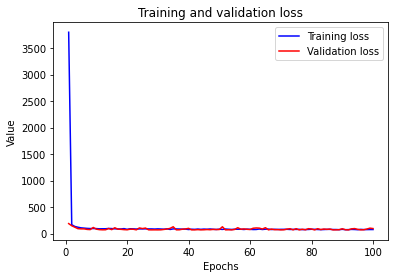

In [34]:
draw_graph(best_history)

In [35]:
print("[INFO] RUNNING ON TEST DATA: \n")
mse, mae = best_model.evaluate(x_test, y_test, verbose=1)
print(f"[INFO] Mean squared error is {mse}")
print(f"[INFO] Mean absolute error is {mae}")

[INFO] RUNNING ON TEST DATA: 

40/40 [==============================] - 0s 2ms/step - loss: 116.7027 - mae: 8.4137
[INFO] Mean squared error is 116.70270538330078
[INFO] Mean absolute error is 8.413687705993652


Предсказываем на модели, которую тюнер выбрал лучшей

In [36]:
best_predicted_y = best_model.predict(x_test)

Считаем коэффициент корреляции

In [37]:
best_predicted_y = np.reshape(best_predicted_y, (best_predicted_y.shape[0]))
y_test = np.reshape(y_test, (y_test.shape[0]))
best_cc = np.corrcoef(best_predicted_y, y_test)
best_cc = best_cc[0][1]
print(f'Correlation Coefficient: {best_cc}')

Correlation Coefficient: 0.7055900652675746
